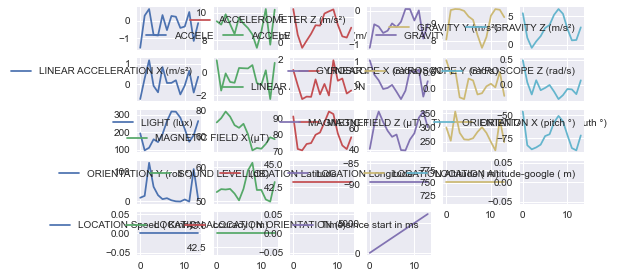

In [51]:
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
from numpy import sin,cos,pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn')
# import data from CSV
df = pd.read_csv('PhoneSensor_record.csv')
# Take a look at all sensor outputs
df.plot(subplots=True,sharex=True,layout=(6,6))
plt.show()

In [52]:
cols_angles = ['ORIENTATION X (pitch °)','ORIENTATION Y (roll °)',
               'ORIENTATION Z (azimuth °)']
for axis in cols_angles:
    df[axis] = df[axis] * pi/180
# Transform body frame accelerations into the inertial (Earth) frame
    # Set up rotation matrices
def R_x(x):
    # body frame rotation about x axis
    return np.array([[1,      0,       0],
                     [0,cos(-x),-sin(-x)],
                     [0,sin(-x), cos(-x)]])
def R_y(y):
    # body frame rotation about y axis
    return np.array([[cos(-y),0,-sin(-y)],
                    [0,      1,        0],
                    [sin(-y), 0, cos(-y)]])
def R_z(z):
    # body frame rotation about z axis
    return np.array([[cos(-z),-sin(-z),0],
                     [sin(-z), cos(-z),0],
                     [0,      0,       1]])
# Set up arrays to hold acceleration data for transformation
accel = np.array([df['ACCELEROMETER X (m/s²)'],
                  df['ACCELEROMETER Y (m/s²)'],
                  df['ACCELEROMETER Z (m/s²)']])
grav = np.array([df['GRAVITY X (m/s²)'],
                 df['GRAVITY Y (m/s²)'],
                 df['GRAVITY Z (m/s²)']])
line = np.array([df['LINEAR ACCELERATION X (m/s²)'],
                 df['LINEAR ACCELERATION Y (m/s²)'],
                 df['LINEAR ACCELERATION Z (m/s²)']])
# Set up arrays to hold Euler angles for rotation matrices
pitch = df['ORIENTATION X (pitch °)']
roll = df['ORIENTATION Y (roll °)']
yaw = df['ORIENTATION Z (azimuth °)']
# Initilize arrays for new transformed accelerations
earth_accels = np.empty(accel.shape)
earth_gravity = np.empty(accel.shape)
earth_linear = np.empty(accel.shape)
# Perform frame transformations (body frame --> earth frame) 
for i in range(df.shape[0]):
    # accel_earth = (RzRyRx)(accel_body)
    earth_accels[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ accel[:,i]
    earth_gravity[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ grav[:,i]
    earth_linear[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ line[:,i]
# Create new columns in dataframe for earth frame accelerations    
df['EARTH ACCELERATION X'] = earth_accels[0,:]
df['EARTH ACCELERATION Y'] = earth_accels[1,:]
df['EARTH ACCELERATION Z'] = earth_accels[2,:]
df['EARTH GRAVITY X'] = earth_gravity[0,:]
df['EARTH GRAVITY Y'] = earth_gravity[1,:]
df['EARTH GRAVITY Z'] = earth_gravity[2,:]
df['EARTH LINEAR ACCELERATION X'] = earth_linear[0,:]
df['EARTH LINEAR ACCELERATION Y'] = earth_linear[1,:]
df['EARTH LINEAR ACCELERATION Z'] = earth_linear[2,:]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:224: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


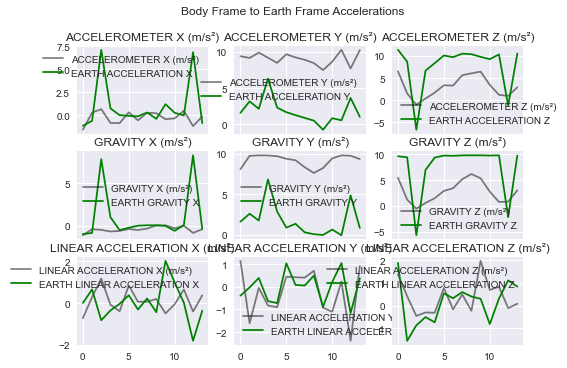

In [53]:
cols_earth = ['EARTH ACCELERATION X','EARTH ACCELERATION Y',
              'EARTH ACCELERATION Z','EARTH GRAVITY X','EARTH GRAVITY Y','EARTH GRAVITY Z','EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']
cols_body = ['ACCELEROMETER X (m/s²)','ACCELEROMETER Y (m/s²)',
             'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)','GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)']
bodyplot = df.plot(y=cols_body,subplots=True,sharex=True,layout=(3,3),style='k',alpha=0.5,title=cols_body)
df.plot(y=cols_earth,subplots=True,layout=(3,3),ax=bodyplot,
sharex=True,style='g',
title='Body Frame to Earth Frame Accelerations')
plt.show()

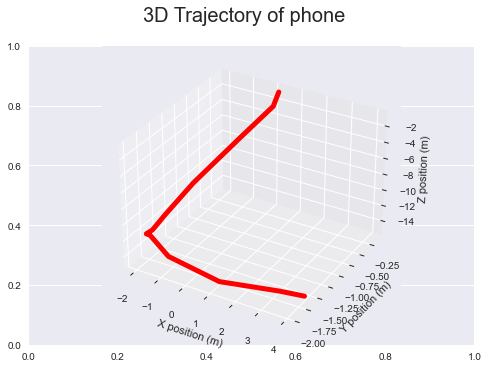

In [69]:
# Double integrate accelerations to find positions
dt = 1
x =cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION X'],dx=dt),dx=dt)
y =cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Y'],dx=dt),dx=dt)
z =cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Z'],dx=dt),dx=dt)
# Plot 3D Trajectory
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
plt.show()

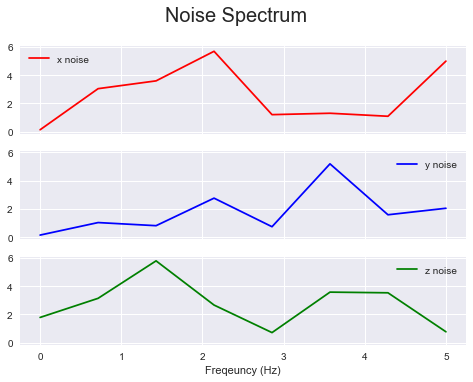

In [62]:
freq = np.fft.rfftfreq(df['EARTH LINEAR ACCELERATION X'].size,d=dt)
# Compute the Fast Fourier Transform (FFT) of acceleration signals
fft_x = np.fft.rfft(df['EARTH LINEAR ACCELERATION X']) 
fft_y = np.fft.rfft(df['EARTH LINEAR ACCELERATION Y']) 
fft_z = np.fft.rfft(df['EARTH LINEAR ACCELERATION Z'])
# Plot Frequency spectrum
fig4,[ax1,ax2,ax3] = plt.subplots(3,1,sharex=True,sharey=True)
fig4.suptitle('Noise Spectrum',fontsize=20)
ax1.plot(freq,abs(fft_x),c='r',label='x noise')
ax1.legend()
ax2.plot(freq,abs(fft_y),c='b',label='y noise')
ax2.legend()
ax3.plot(freq,abs(fft_z),c='g',label='z noise')
ax3.legend()
ax3.set_xlabel('Freqeuncy (Hz)')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:224: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


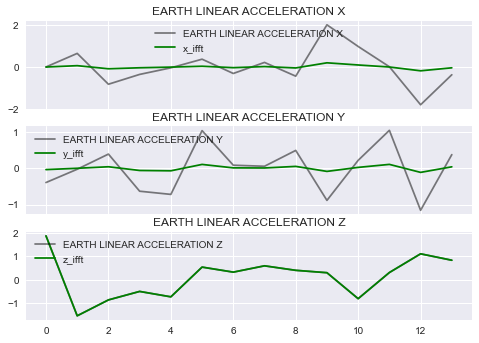

In [63]:
# Attenuate noise in X,Y below 10Hz by 10 dB
# Attenuate noise <10Hz and >5Hz in Z axis by 10 dB
atten_x_fft = np.where(freq < 10,fft_x * 0.1, fft_x) 
atten_y_fft = np.where(freq < 10,fft_y * 0.1, fft_y) 
atten_z_fft = np.where((freq > 5) & (freq < 10),fft_z * 0.1, fft_z) 
# Compute inverse of discrete Fourier Transform 
df['x_ifft'] = np.fft.irfft(atten_x_fft,n=df.shape[0])
df['y_ifft'] = np.fft.irfft(atten_y_fft,n=df.shape[0])
df['z_ifft'] = np.fft.irfft(atten_z_fft,n=df.shape[0])
# Plot new acceleration signals
cols_raw = ['EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']
cols_new = ['x_ifft','y_ifft','z_ifft']
rawplot = df.plot(y=cols_raw,subplots=True,sharex=True, style='k',title=cols_raw,alpha=0.5)
df.plot(y=cols_new,subplots=True,layout=(1,3),ax=rawplot, sharex=True,style='g')
plt.show()

In [64]:
x = cumtrapz(cumtrapz(df['x_ifft'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(df['y_ifft'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(df['z_ifft'],dx=dt),dx=dt)
# Plot attenuated 3D Trajectory
ax.plot3D(x,y,z,'k',lw=5,label='Attenuated phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')
plt.show()

In [65]:
# Add XYZ axis arrows to indicate phone pose
    # Earth 3 axis unit vectors
earth_x = np.array([[1,0,0],]*len(x)).T
earth_y = np.array([[0,1,0],]*len(x)).T
earth_z = np.array([[0,0,1],]*len(x)).T
# Initialize body Vectors
body_x = np.empty(earth_x.shape)
body_y = np.empty(earth_y.shape)
body_z = np.empty(earth_z.shape)
# Perform inverse frame transformations (body frame <-- earth frame) 
    # body_vectors = (RxRyRz)(earth_vectors)
for i in range(x.shape[0]):
    # use negative angles to reverse rotation
    body_x[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @earth_x[:,i]
    body_y[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @ earth_y[:,i]
    body_z[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @ earth_z[:,i]

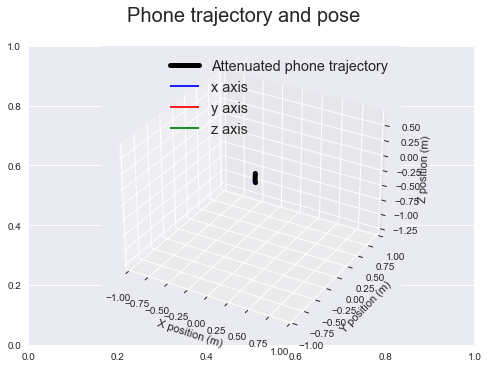

In [66]:
# Set length of quiver arrows    
distance = np.sqrt(x[-1]**2 + y[-1]**2 + z[-1]**2)
length = 0.05 * distance
# Plot x vectors
    # downsampling to every 10th arrow ([::10])
fig6,ax4 = plt.subplots()
fig6.suptitle('Phone trajectory and pose',fontsize=20)
ax4 = plt.axes(projection='3d')
ax4.plot3D(x,y,z,'k',lw=5,label='Attenuated phone trajectory')
# plot x vectors
ax4.quiver(x[::10],y[::10],z[::10],
          body_x[0][::10],body_x[1][::10],body_x[2][::10],
          color='b',label = 'x axis',length = length)
# Plot y vectors
ax4.quiver(x[::10],y[::10],z[::10],
          body_y[0][::10],body_y[1][::10],body_y[2][::10],
          color='r',label = 'y axis',length = length)
# Plot Z vectors
ax4.quiver(x[::10],y[::10],z[::10],
          body_z[0][::10],body_z[1][::10],body_z[2][::10],
          color='g',label = 'z axis',length = length)
ax4.set_xlabel('X position (m)')
ax4.set_ylabel('Y position (m)')
ax4.set_zlabel('Z position (m)')
ax4.set_xlim(-1,1)# may need to vary
ax4.set_ylim(-1,1)
ax4.set_zlim(-1.3,0.7)
ax4.legend(fontsize='x-large')
plt.show()